# Part 3
## Question 1

In [156]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import time


In [157]:
def asian_geom_option_price_analytical(S0, K, r, sigma, T, N):
    # Analytical solution for the price of an Asian geometric average option
    sigma_tilde = sigma * np.sqrt((2 * N + 1)/(6 * (N + 1)))
    r_tilde = (r - 0.5 * sigma**2 + sigma_tilde**2) / 2

    d1 = (np.log(S0/K) + (r_tilde + 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))
    d2 = (np.log(S0/K) + (r_tilde - 0.5 * sigma_tilde**2) * T) / (sigma_tilde * np.sqrt(T))
    C_analytical = np.exp(-r * T) * (S0 * np.exp(r_tilde * T) * norm.cdf(d1) - K * norm.cdf(d2))
    return C_analytical

In [177]:
def asian_geom_option_price_simul(S0, K, r, sigma, T, N, M, seed=None):
    # Simulate the price of an Asian geometric average option
    dt = T / N

    # Monte-Carlo simulations
    np.random.seed(seed)
    A_N = np.zeros(M)
    for i in range(M):
        S = np.zeros(N+1)
        S[0] = S0
        for j in range(1, N+1):
            S[j] = S[j-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.standard_normal())
    
        # A_N[i] = np.prod(S)**(1/(N + 1))
        subsets = [S[i:i+50] for i in range(0, len(S), 50)]
        A_N[i] = np.prod([np.prod(S)**(1/(N + 1)) for S in subsets])
    return np.exp(-r * T) * np.maximum(A_N - K, 0).mean(), np.maximum(A_N - K, 0)

The price of the Asian option based on geometric averages using the analytical expression is 6.331828080598059
The price of the Asian option based on geometric averages using Monte-Carlo simulations is 6.3344227828493995


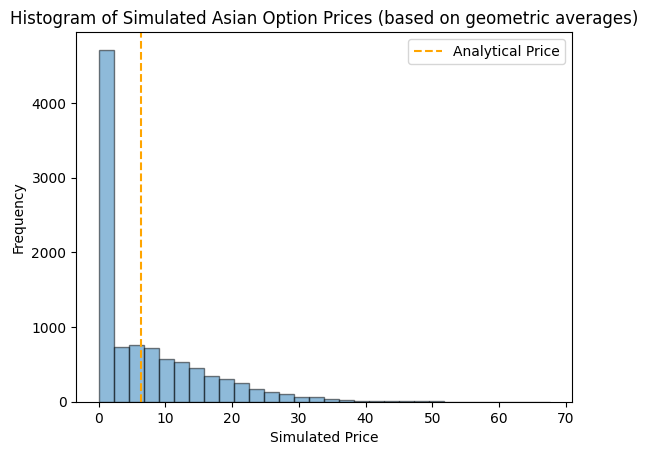

In [202]:
# Settling the parameters
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1
N = 365

# Analytical:
C_analytical = asian_geom_option_price_analytical(S0, K, r, sigma, T, N)
print('The price of the Asian option based on geometric averages using the analytical expression is', C_analytical)

# Simulated:
M = 10000 # Number of simulations
C_simulated, C = asian_geom_option_price_simul(S0, K, r, sigma, T, N, M)
print('The price of the Asian option based on geometric averages using Monte-Carlo simulations is', C_simulated)

# Plot C_simulated histogram, with vertical line at C_analytical
plt.hist(C, bins=30, edgecolor='k', alpha=0.5)
plt.axvline(x=C_analytical, color='orange', linestyle='--', label='Analytical Price')
plt.title('Histogram of Simulated Asian Option Prices (based on geometric averages)')
plt.xlabel('Simulated Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()



## Question 2
- Geometric average strongly correlated to the arithmetic average.
- We know the exact answer to the expected value for the geometric average.
- Together, these two make that the geometric average is a good control variate.
- $\lambda$ is unknown so we use sample variance and covariance for that.

## Question 3

In [191]:
def asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, seed=None, control_variate=False):
    # Simulate the price of an Asian arithmetic average option
    dt = T / N

    # Monte-Carlo simulations
    np.random.seed(seed)
    A_N_arith = np.zeros(M)
    A_N_geom = np.zeros(M)

    for i in range(M):
        S = np.zeros(N+1)
        S[0] = S0
        for j in range(1, N+1):
            S[j] = S[j-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.standard_normal())
        
        A_N_arith[i] = S.mean()

        if control_variate:
            # Subsets of size 50 (this way we avoid overflow errors and zeroes):
            subsets = [S[i:i+50] for i in range(0, len(S), 50)]
            A_N_geom[i] = np.prod([np.prod(S)**(1/(N + 1)) for S in subsets])

    payoff_arith = np.maximum(A_N_arith - K, 0)
    price_arith = np.exp(-r * T) * payoff_arith

    if control_variate:
        payoff_geom = np.maximum(A_N_geom - K, 0)
        price_geom = np.exp(-r * T) * payoff_geom

        exact_geom_price = asian_geom_option_price_analytical(S0, K, r, sigma, T, N)
        sample_var = np.var(price_geom)
        sample_covar = np.cov(price_geom, price_arith)[0, 1]
        
        sample_lambda = sample_covar / sample_var

        price_controlled = (price_arith - sample_lambda * (price_geom - exact_geom_price))

        return price_controlled.mean(), price_controlled

    return price_arith.mean(), price_arith

In [193]:
# Settling the parameters
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1
N = 365 # Fixed the overflow error by combining the products and exponents in subsets

# Simulated:
M = 100 # Number of simulations
start = time.time()
C_control_variate, prices_control = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
control_time = time.time() - start
C_original, prices_original = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
original_time = time.time() - start - control_time
print(f"Price Estimated using control variate: {C_control_variate} in {control_time} seconds. Prices had variance {np.var(prices_control)}")
print(f"Price Estimated without control variate: {C_original} in {original_time} seconds. Prices had variance {np.var(prices_original)}")

Price Estimated using control variate: 6.576247212049584 in 0.09108924865722656 seconds. Prices had variance 0.05848204727854858
Price Estimated without control variate: 5.211441324828355 in 0.0717620849609375 seconds. Prices had variance 57.03096920444158


Price Estimated using control variate: 5.761024977840796 in 7.39717698097229 seconds. Prices had variance 0.05007790015329429
Price Estimated without control variate: 5.670999368124058 in 7.1549224853515625 seconds. Prices had variance 65.06263116060735
The price of the Asian option based on arithmetic averages using Monte-Carlo simulations with control variate is 5.761024977840796
The price of the Asian option based on arithmetic averages using Monte-Carlo simulations without control variate is 5.670999368124058


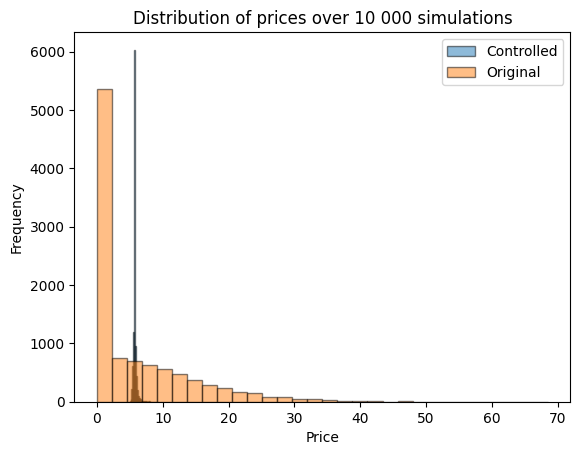

In [194]:
# Settling the parameters
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1
N = 365 # Fixed the overflow error by combining the products and exponents in subsets

# Simulated:
M = 10000 # Number of simulations
start = time.time()
C_control_variate, prices_control = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
control_time = time.time() - start
C_original, prices_original = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
original_time = time.time() - start - control_time
print(f"Price Estimated using control variate: {C_control_variate} in {control_time} seconds. Prices had variance {np.var(prices_control)}")
print(f"Price Estimated without control variate: {C_original} in {original_time} seconds. Prices had variance {np.var(prices_original)}")
print('The price of the Asian option based on arithmetic averages using Monte-Carlo simulations with control variate is', C_control_variate)
print('The price of the Asian option based on arithmetic averages using Monte-Carlo simulations without control variate is', C_original)


# # Plot them together
# plt.hist(payoffs_control, bins=30, edgecolor='k', alpha=0.5, label='Controlled')
# plt.hist(payoffs_original, bins=30, edgecolor='k', alpha=0.5, label='Original')
# plt.title('Distribution of payoffs over 10 000 simulations')
# plt.xlabel('Payoff')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

# Prices histograms
plt.hist(prices_control, bins=30, edgecolor='k', alpha=0.5, label='Controlled')
plt.hist(prices_original, bins=30, edgecolor='k', alpha=0.5, label='Original')
plt.title('Distribution of prices over 10 000 simulations')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()



Varying the number of paths?? is M?

Finding the convergence of the option price for increased simulations: 100%|██████████| 29/29 [02:39<00:00,  5.50s/it]


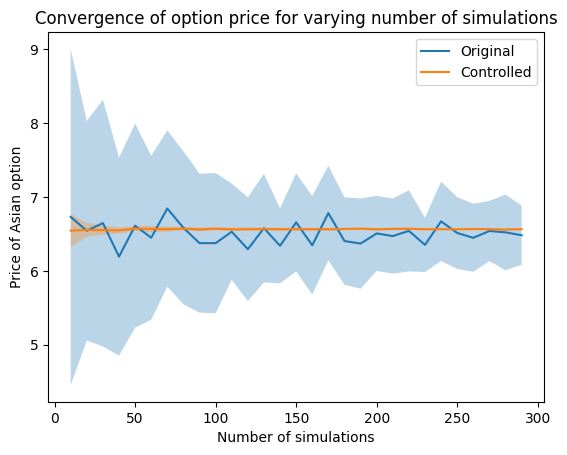

In [195]:
# Settling the parameters
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1
N = 365 # Fixed the overflow error by combining the products and exponents in subsets
#M = 100 # Number of simulations


path_range = np.arange(10,300,10) # set 1000 instead of 50 for the resut in report
pi_values_controlled = []    # To store the results
pi_values_original = []
pi_vars_controlled = []    # To store the variance
pi_vars_original = []

repetitions = 25 # repetitions to find the variance for one M

for M in tqdm(path_range, desc='Finding the convergence of the option price for increased simulations'):
    values_original = []
    values_controlled = []
    for reps in range(repetitions):
        option_control_variate,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
        option_original,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
        values_controlled.append(option_control_variate)
        values_original.append(option_original)

    pi_values_controlled.append(np.mean(values_controlled))
    pi_values_original.append(np.mean(values_original))
    pi_vars_controlled.append(np.var(values_controlled))
    pi_vars_original.append(np.var(values_original))

# Plot the results, with variance as fill_between
plt.plot(path_range, pi_values_original, label='Original')
plt.fill_between(path_range, np.array(pi_values_original) - np.sqrt(pi_vars_original), np.array(pi_values_original) + np.sqrt(pi_vars_original), alpha=0.3)
plt.plot(path_range, pi_values_controlled, label='Controlled')
plt.fill_between(path_range, np.array(pi_values_controlled) - np.sqrt(pi_vars_controlled), np.array(pi_values_controlled) + np.sqrt(pi_vars_controlled), alpha=0.3)
plt.xlabel('Number of simulations')
plt.ylabel('Price of Asian option')
plt.title("Convergence of option price for varying number of simulations")
plt.legend()
plt.show()

Finding the convergence of the option price for increased simulations (K=80): 100%|██████████| 10/10 [00:53<00:00,  5.39s/it]


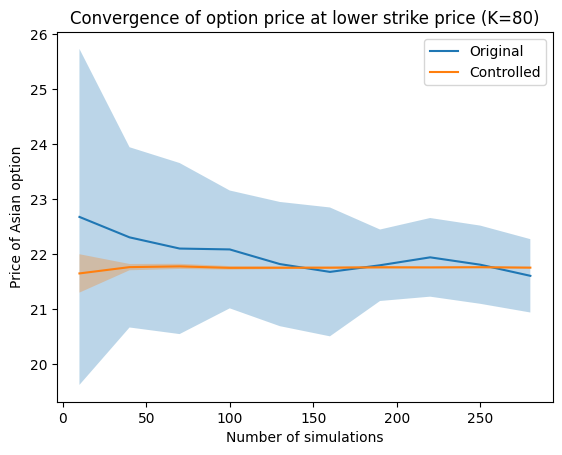

Finding the convergence of the option price for increased simulations (K=120):   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Admin\AppData\Local\Temp\ipykernel_7768\1225759892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  sample_lambda = sample_covar / sample_var
Finding the convergence of the option price for increased simulations (K=120): 100%|██████████| 10/10 [00:53<00:00,  5.31s/it]


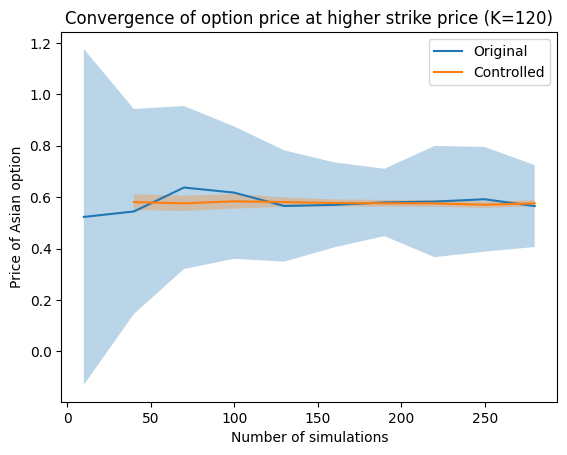

In [197]:
# Settling the parameters
S0 = 100
K = 80
r = 0.06
sigma = 0.2
T = 1
N = 365 # Fixed the overflow error by combining the products and exponents in subsets

path_range = np.arange(10,300,30) # set 1000 instead of 50 for the resut in report
pi_values_controlled = []    # To store the results
pi_values_original = []
pi_vars_controlled = []    # To store the variance
pi_vars_original = []

repetitions = 25 # repetitions to find the variance for one M

for M in tqdm(path_range, desc=f'Finding the convergence of the option price for increased simulations (K={K})'):
    values_original = []
    values_controlled = []
    for reps in range(repetitions):
        option_control_variate,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
        option_original,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
        values_controlled.append(option_control_variate)
        values_original.append(option_original)

    pi_values_controlled.append(np.mean(values_controlled))
    pi_values_original.append(np.mean(values_original))
    pi_vars_controlled.append(np.var(values_controlled))
    pi_vars_original.append(np.var(values_original))

# Plot the results, with variance as fill_between
plt.plot(path_range, pi_values_original, label='Original')
plt.fill_between(path_range, np.array(pi_values_original) - np.sqrt(pi_vars_original), np.array(pi_values_original) + np.sqrt(pi_vars_original), alpha=0.3)
plt.plot(path_range, pi_values_controlled, label='Controlled')
plt.fill_between(path_range, np.array(pi_values_controlled) - np.sqrt(pi_vars_controlled), np.array(pi_values_controlled) + np.sqrt(pi_vars_controlled), alpha=0.3)
plt.xlabel('Number of simulations')
plt.ylabel('Price of Asian option')
plt.title(f"Convergence of option price at lower strike price (K={K})")
plt.legend()
plt.show()

# Settling the parameters
S0 = 100
K = 120
r = 0.06
sigma = 0.2
T = 1
N = 365 # Fixed the overflow error by combining the products and exponents in subsets

path_range = np.arange(10,300,30) # set 1000 instead of 50 for the resut in report
pi_values_controlled = []    # To store the results
pi_values_original = []
pi_vars_controlled = []    # To store the variance
pi_vars_original = []

repetitions = 25 # repetitions to find the variance for one M

for M in tqdm(path_range, desc=f'Finding the convergence of the option price for increased simulations (K={K})'):
    values_original = []
    values_controlled = []
    for reps in range(repetitions):
        option_control_variate,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
        option_original,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
        values_controlled.append(option_control_variate)
        values_original.append(option_original)

    pi_values_controlled.append(np.mean(values_controlled))
    pi_values_original.append(np.mean(values_original))
    pi_vars_controlled.append(np.var(values_controlled))
    pi_vars_original.append(np.var(values_original))

# Plot the results, with variance as fill_between
plt.plot(path_range, pi_values_original, label='Original')
plt.fill_between(path_range, np.array(pi_values_original) - np.sqrt(pi_vars_original), np.array(pi_values_original) + np.sqrt(pi_vars_original), alpha=0.3)
plt.plot(path_range, pi_values_controlled, label='Controlled')
plt.fill_between(path_range, np.array(pi_values_controlled) - np.sqrt(pi_vars_controlled), np.array(pi_values_controlled) + np.sqrt(pi_vars_controlled), alpha=0.3)
plt.xlabel('Number of simulations')
plt.ylabel('Price of Asian option')
plt.title(f"Convergence of option price at higher strike price (K={K})")
plt.legend()
plt.show()

Finding the convergence of the option price for increased simulations (K=99): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


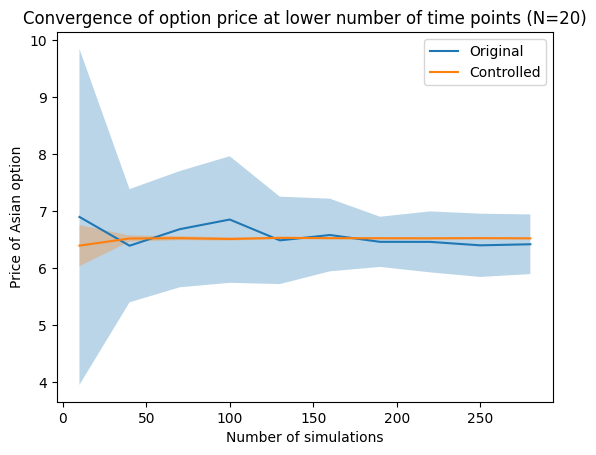

In [198]:
# Settling the parameters
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1
N = 20

path_range = np.arange(10,300,30) # set 1000 instead of 50 for the resut in report
pi_values_controlled = []    # To store the results
pi_values_original = []
pi_vars_controlled = []    # To store the variance
pi_vars_original = []

repetitions = 25 # repetitions to find the variance for one M

for M in tqdm(path_range, desc=f'Finding the convergence of the option price for increased simulations (K={K})'):
    values_original = []
    values_controlled = []
    for reps in range(repetitions):
        option_control_variate,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
        option_original,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
        values_controlled.append(option_control_variate)
        values_original.append(option_original)

    pi_values_controlled.append(np.mean(values_controlled))
    pi_values_original.append(np.mean(values_original))
    pi_vars_controlled.append(np.var(values_controlled))
    pi_vars_original.append(np.var(values_original))

# Plot the results, with variance as fill_between
plt.plot(path_range, pi_values_original, label='Original')
plt.fill_between(path_range, np.array(pi_values_original) - np.sqrt(pi_vars_original), np.array(pi_values_original) + np.sqrt(pi_vars_original), alpha=0.3)
plt.plot(path_range, pi_values_controlled, label='Controlled')
plt.fill_between(path_range, np.array(pi_values_controlled) - np.sqrt(pi_vars_controlled), np.array(pi_values_controlled) + np.sqrt(pi_vars_controlled), alpha=0.3)
plt.xlabel('Number of simulations')
plt.ylabel('Price of Asian option')
plt.title(f"Convergence of option price at lower number of time points (N={N})")
plt.legend()
plt.show()


Varing the strike price K

Finding the strike price's effect on the option price:  80%|████████  | 8/10 [00:29<00:07,  3.69s/it]C:\Users\Admin\AppData\Local\Temp\ipykernel_7768\1225759892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  sample_lambda = sample_covar / sample_var
Finding the strike price's effect on the option price: 100%|██████████| 10/10 [00:36<00:00,  3.68s/it]


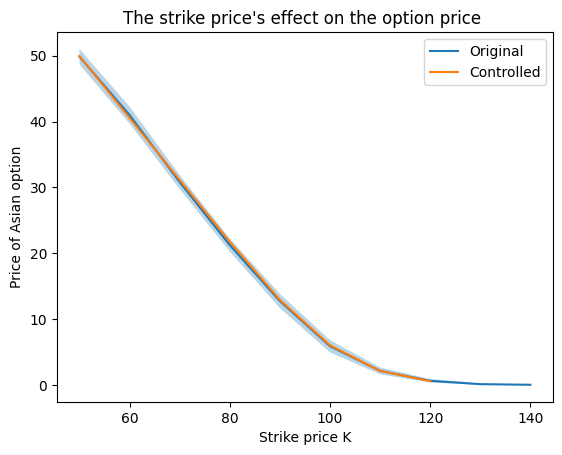

In [199]:
# Settling the parameters
S0 = 100
# K = 99
r = 0.06
sigma = 0.2
T = 1
N = 365 # Fixed the overflow error by combining the products and exponents in subsets
M = 100 # Number of simulations


strike_price_range = np.arange(50,150,10) # set 500 instead of 50 for the resut in report
pi_values_controlled = []    # To store the results
pi_values_original = []
pi_vars_controlled = []    # To store the variance
pi_vars_original = []

repetitions = 25 # repetitions to find the variance for one strike price

for K in tqdm(strike_price_range, desc="Finding the strike price's effect on the option price"):
    values_original = []
    values_controlled = []
    for reps in range(repetitions):
        option_control_variate,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
        option_original,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
        values_controlled.append(option_control_variate)
        values_original.append(option_original)
    
    pi_values_controlled.append(np.mean(values_controlled))
    pi_values_original.append(np.mean(values_original))
    pi_vars_controlled.append(np.var(values_controlled))
    pi_vars_original.append(np.var(values_original))

# Plot the results, with variance as fill_between
plt.plot(strike_price_range, pi_values_original, label='Original')
plt.fill_between(strike_price_range, np.array(pi_values_original) - np.sqrt(pi_vars_original), np.array(pi_values_original) + np.sqrt(pi_vars_original), alpha=0.3)
plt.plot(strike_price_range, pi_values_controlled, label='Controlled')
plt.fill_between(strike_price_range, np.array(pi_values_controlled) - np.sqrt(pi_vars_controlled), np.array(pi_values_controlled) + np.sqrt(pi_vars_controlled), alpha=0.3)
plt.xlabel('Strike price K')
plt.ylabel('Price of Asian option')
plt.title("The strike price's effect on the option price ")
plt.legend()
plt.show()


Varing the number of time points N?

Finding the convergence of the option price for increased timepoints: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]


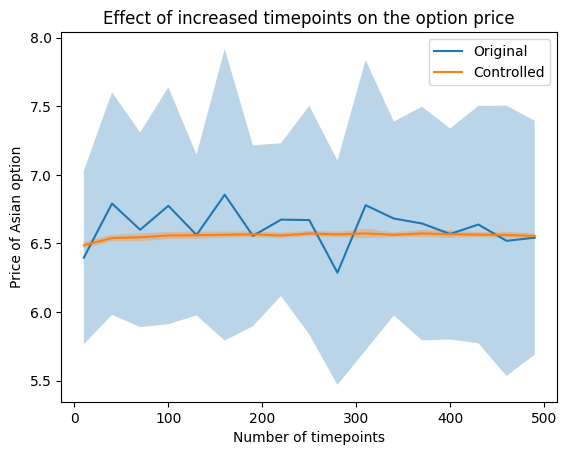

In [200]:
# Settling the parameters
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1
# N = 365 # Fixed the overflow error by combining the products and exponents in subsets
M = 100 # Number of simulations


timepoints_range = np.arange(10,500,30) # vary the timepoints
pi_values_controlled = []    # To store the results
pi_values_original = []
pi_vars_controlled = []    # To store the variance
pi_vars_original = []

repetitions = 25 # repetitions to find the variance for one N

for N in tqdm(timepoints_range, desc='Finding the convergence of the option price for increased timepoints'):
    values_original = []
    values_controlled = []
    for reps in range(repetitions):
        option_control_variate,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=True)
        option_original,_ = asian_arith_option_price_simul(S0, K, r, sigma, T, N, M, control_variate=False)
        values_controlled.append(option_control_variate)
        values_original.append(option_original)
    
    pi_values_controlled.append(np.mean(values_controlled))
    pi_values_original.append(np.mean(values_original))
    pi_vars_controlled.append(np.var(values_controlled))
    pi_vars_original.append(np.var(values_original))

# Plot the results, with variance as fill_between
plt.plot(timepoints_range, pi_values_original, label='Original')
plt.fill_between(timepoints_range, np.array(pi_values_original) - np.sqrt(pi_vars_original), np.array(pi_values_original) + np.sqrt(pi_vars_original), alpha=0.3)
plt.plot(timepoints_range, pi_values_controlled, label='Controlled')
plt.fill_between(timepoints_range, np.array(pi_values_controlled) - np.sqrt(pi_vars_controlled), np.array(pi_values_controlled) + np.sqrt(pi_vars_controlled), alpha=0.3)
plt.xlabel('Number of timepoints')
plt.ylabel('Price of Asian option')
plt.title("Effect of increased timepoints on the option price")
plt.legend()
plt.show()